# US Name

Data preparation combine table information and journals


# Description

None

## Merge

**Main table** 

papers_meta_analysis_new

Merged with:

- papers_meta_analysis
- journals_scimago

# Target

- The file is saved in S3:
- bucket: datalake-datascience
- path: DATA/FINANCE/ESG/ESG_CFP
- Glue data catalog should be updated
- database: esg
- Table prefix: meta_analysis_
- table name: meta_analysis_esg_cfp
- Analytics
- HTML: ANALYTICS/HTML_OUTPUT/meta_analysis_esg_cfp
- Notebook: ANALYTICS/OUTPUT/meta_analysis_esg_cfp

# Metadata

- Key: 234_esg_metadata
- Epic: Dataset transformation
- US: Prepare meta-analysis table
- Task tag: #journal-information, #papers-information
- Analytics reports: https://htmlpreview.github.io/?https://github.com/thomaspernet/esg_metadata/blob/master/00_data_catalog/HTML_ANALYSIS/META_ANALYSIS_ESG_CFP.html

# Input

## Table/file

**Name**

- papers_meta_analysis_new
- papers_meta_analysis
- journals_scimago

**Github**

- https://github.com/thomaspernet/esg_metadata/blob/master/01_data_preprocessing/01_transform_tables/00_meta_analysis.md

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import os, shutil, json, re

path = os.getcwd()
parent_path = str(Path(path).parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-2'
bucket = 'datalake-london'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = True) 
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

# Prepare query 

Write query and save the CSV back in the S3 bucket `datalake-datascience` 

# Steps

## Merge journal and papers table

In [ ]:
DatabaseName = 'esg'
s3_output_example = 'SQL_OUTPUT_ATHENA'

In [ ]:
query = """
WITH merge AS (
  SELECT 
    id, 
    image,
    row_id_excel,
    table_refer,
    row_id_google_spreadsheet,
    incremental_id,
    paper_name, 
    publication_year, 
    publication_type, 
    regexp_replace(
      regexp_replace(
        lower(publication_name), 
        '\&', 
        'and'
      ), 
      '\-', 
      ' '
    ) as publication_name, 
    cnrs_ranking, 
    UPPER(peer_reviewed) as peer_reviewed, 
    UPPER(study_focused_on_social_environmental_behaviour) as study_focused_on_social_environmental_behaviour, 
    type_of_data, 
    CASE WHEN regions = 'ARAB WORLD' THEN 'WORLDWIDE' ELSE regions END AS regions,
    CASE WHEN study_focusing_on_developing_or_developed_countries = 'Europe' THEN 'WORLDWIDE' ELSE UPPER(study_focusing_on_developing_or_developed_countries) END AS study_focusing_on_developing_or_developed_countries,
    first_date_of_observations,
    last_date_of_observations,
    CASE WHEN first_date_of_observations >= 1997 THEN 'YES' ELSE 'NO' END AS kyoto,
    CASE WHEN first_date_of_observations >= 2009 THEN 'YES' ELSE 'NO' END AS financial_crisis,
    last_date_of_observations - first_date_of_observations as windows,
    adjusted_model_name,
    adjusted_model,
    dependent, 
    adjusted_dependent,
    independent,
    adjusted_independent, 
    social,
    environmental,
    governance,
    sign_of_effect,
    target,
    p_value_significant,
    sign_positive,
    sign_negative,
    lag, 
    interaction_term, 
    quadratic_term, 
    n, 
    r2, 
    beta, 
    to_remove,
    test_standard_error,
    test_p_value,
    test_t_value,
    adjusted_standard_error,
    adjusted_t_value
  FROM 
    esg.papers_meta_analysis_new 
    LEFT JOIN (
      SELECT 
        DISTINCT(title),
        nr, 
        publication_year, 
        publication_type, 
        publication_name, 
        cnrs_ranking, 
        peer_reviewed, 
        study_focused_on_social_environmental_behaviour, 
        type_of_data, 
        study_focusing_on_developing_or_developed_countries
      FROM 
        esg.papers_meta_analysis
    ) as old on papers_meta_analysis_new.id = old.nr
    -- WHERE to_remove = 'TO_KEEP'
LEFT JOIN (
SELECT 
        nr,
        CAST(MIN(first_date_of_observations) as int) as first_date_of_observations,
        CAST(MAX(last_date_of_observations)as int) as last_date_of_observations,
        min(row_id_excel) as row_id_excel
      FROM 
        esg.papers_meta_analysis
        GROUP BY nr
) as date_pub on papers_meta_analysis_new.id = date_pub.nr
LEFT JOIN (
SELECT 
  nr, 
  MIN(regions) as regions 
FROM 
  (
    SELECT 
      nr, 
      CASE WHEN regions_of_selected_firms in (
        'Cameroon', 'Egypt', 'Libya', 'Morocco', 
        'Nigeria'
      ) THEN 'AFRICA' WHEN regions_of_selected_firms in ('GCC countries') THEN 'ARAB WORLD' WHEN regions_of_selected_firms in (
        'India', 'Indonesia', 'Taiwan', 'Vietnam', 
        'Australia', 'China', 'Iran', 'Malaysia', 
        'Pakistan', 'South Korea', 'Bangladesh'
      ) THEN 'ASIA AND PACIFIC' WHEN regions_of_selected_firms in (
        'Spain', '20 European countries', 
        'United Kingdom', 'France', 'Germany, Italy, the Netherlands and United Kingdom', 
        'Turkey', 'UK'
      ) THEN 'EUROPE' WHEN regions_of_selected_firms in ('Latin America', 'Brazil') THEN 'LATIN AMERICA' WHEN regions_of_selected_firms in ('USA', 'US', 'U.S.', 'Canada') THEN 'NORTH AMERICA' ELSE 'WORLDWIDE' END AS regions 
    FROM 
      papers_meta_analysis
  ) 
GROUP BY 
  nr
) as reg on papers_meta_analysis_new.id = reg.nr
) 
SELECT 
    to_remove, 
    id, 
    image,
    row_id_excel,
    row_id_google_spreadsheet,
    table_refer,
    incremental_id,
    paper_name,
    publication_name,
    rank,
    sjr, 
    sjr_best_quartile, 
    h_index, 
    total_docs_2020, 
    total_docs_3years, 
    total_refs, 
    total_cites_3years, 
    citable_docs_3years, 
    cites_doc_2years, 
    country ,
    publication_year, 
    publication_type, 
    cnrs_ranking, 
    peer_reviewed, 
    study_focused_on_social_environmental_behaviour, 
    type_of_data, 
    regions,
    study_focusing_on_developing_or_developed_countries,
    first_date_of_observations,
    last_date_of_observations - (windows/2) as mid_year,
    last_date_of_observations,
    kyoto,
    financial_crisis,
    windows,
    adjusted_model_name,
    adjusted_model,
    dependent, 
    adjusted_dependent,
    independent,
    adjusted_independent, 
    social,
    environmental,
    governance,
    sign_of_effect,
    target,
    p_value_significant,
    sign_positive,
    sign_negative,
    lag, 
    interaction_term, 
    quadratic_term, 
    n, 
    r2, 
    beta, 
    test_standard_error,
    test_p_value,
    test_t_value,
    adjusted_standard_error,
    adjusted_t_value 
FROM 
  merge 
  LEFT JOIN (
    SELECT 
      rank, 
      regexp_replace(
        regexp_replace(
          lower(title), 
          '\&', 
          'and'
        ), 
        '\-', 
        ' '
      ) as title, 
      sjr, 
      sjr_best_quartile, 
      h_index, 
      total_docs_2020, 
      total_docs_3years, 
      total_refs, 
      total_cites_3years, 
      citable_docs_3years, 
      cites_doc_2years, 
      country 
    FROM 
      "scimago"."journals_scimago"
    WHERE sourceid not in (16400154787)
  ) as journal on merge.publication_name = journal.title
"""
output = (
    s3.run_query(
    query=query,
    database=DatabaseName,
    s3_output=s3_output_example,
    filename='example_1',
        dtype = {'publication_year':'string'}
)
    .sort_values(by = ['id', 'first_date_of_observations'])
    .drop_duplicates()
    .assign(weight = lambda x: x.groupby(['id'])['id'].transform('size'))
)
output.head()

In [ ]:
output.shape

In [ ]:
output.describe()

In [ ]:
output['weight'].describe()

In [ ]:
#output[output.duplicated(subset = ['id', 'beta',
#                                   'true_standard_error', 'critical_value', 'lag', 'independent',
#                                  'true_t_value', 'true_stars', 'adjusted_model'
#                                  ])].head()

Missing journals

In [ ]:
output.loc[lambda x: x['rank'].isin([np.nan])]['publication_name'].unique()

Currently, the missing values come from the rows to check in [METADATA_TABLES_COLLECTION](https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=899172650)

In [ ]:
output.isna().sum().loc[lambda x: x> 0].sort_values()

## Explain missings:

### Date

- 'Does Corporate Social Responsibility Pay Off in Times of Crisis? An Alternate Perspective on the Relationship between Financial and Corporate Social Performance':
    - No date
- 'How does corporate social responsibility contribute to firm financial performance? The mediating role of competitive advantage reputation and customer satisfaction',
    - No date
- 'L’impact de la responsabilité sociale (RSE) sur la performance financière des entreprises (PFE) au Cameroun'
    - Poor date formating: 2007 Semester I, 2007 Semester I

In [ ]:
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

In [ ]:
(
    output
    .loc[lambda x: x['first_date_of_observations'].isin([np.nan])]
    .reindex(columns = ['paper_name', 'row_id_excel'])
    .drop_duplicates()
    .style
    .format(make_clickable, subset = ['row_id_excel'])
)

### location

- Corporate social responsibility and financial performance in Islamic banks
    - Missing
- Corporate social responsibility and financial performance: the ‘‘virtuous circle’’ revisited
    - Missing

In [ ]:
(
    output
    .loc[lambda x: x['study_focusing_on_developing_or_developed_countries'].isin([np.nan])]
    .reindex(columns = ['paper_name', 'row_id_excel'])
    .drop_duplicates()
    .style
    .format(make_clickable, subset = ['row_id_excel'])
)

### peer_reviewed

- L’impact de la responsabilité sociale (RSE) sur la performance financière des entreprises (PFE) au Cameroun
    - Missing
- Looking for evidence of the relationship between CSR and CFP in an Emerging Market
    - Missing
- The Relationship of CSR and Financial Performance: New Evidence From Indonesian Companies
    - Missing
- Exploring the moderating effect of financial performance on the relationship between corporate environmental responsibility and institutional investors: some Egyptian evidence
    - Missing
- STRATEGIC USE OF CSR AS A SIGNAL FOR GOOD MANAGEMENT
    - Missing

In [ ]:
(
    output
    .loc[lambda x: x['peer_reviewed'].isin([np.nan])]
    .reindex(columns = ['paper_name', 'row_id_excel'])
    .drop_duplicates()
    .style
    .format(make_clickable, subset = ['row_id_excel'])
)

## adjusted_independent

- Need to be adjusted

In [ ]:
(
    output
    .loc[lambda x: x['adjusted_independent'].isin([np.nan])]
    .reindex(columns = ['paper_name', 'row_id_google_spreadsheet'])
    .drop_duplicates()
    .head(5)
    .style
    .format(make_clickable, subset = ['row_id_google_spreadsheet'])
)

### Save data to Google Spreadsheet for sharing

- Link: [METADATA_MODEL](https://docs.google.com/spreadsheets/d/13gpRy93l7POWGe-rKjytt7KWOcD1oSLACngTEpuqCTg/edit#gid=0)

In [ ]:
#!pip install --upgrade git+git://github.com/thomaspernet/GoogleDrive-python

In [5]:
from GoogleDrivePy.google_drive import connect_drive
from GoogleDrivePy.google_platform import connect_cloud_platform
from GoogleDrivePy.google_authorization import authorization_service

In [ ]:
try:
    os.mkdir("creds")
except:
    pass

In [ ]:
s3.download_file(key = "CREDS/Financial_dependency_pollution/creds/token.pickle", path_local = "creds")
s3.download_file(key = "CREDS/Financial_dependency_pollution/creds/service.json", path_local = "creds")

In [6]:
auth = authorization_service.get_authorization(
    path_credential_gcp=os.path.join(path, "creds", "service.json"),
    path_credential_drive=os.path.join(path, "creds"),
    verbose=False,
    scope=['https://www.googleapis.com/auth/spreadsheets.readonly',
           "https://www.googleapis.com/auth/drive"]
)
gd_auth = auth.authorization_drive(path_secret=os.path.join(
    path, "creds", "credentials.json"))
service_account = auth.authorization_gcp()
drive = connect_drive.drive_operations(gd_auth)

In [ ]:
import shutil
shutil.rmtree(os.path.join(path,"creds"))

In [ ]:
FILENAME_SPREADSHEET = "METADATA_MODEL"
spreadsheet_id = drive.find_file_id(FILENAME_SPREADSHEET, to_print=False)

In [ ]:
drive.add_data_to_spreadsheet(
    data =output.fillna(""),
    sheetID =spreadsheet_id,
    sheetName = "MODEL_DATA",
    detectRange = True,
    rangeData = None)

# Download authors and paper information

## Semantic scholar

Extract paper name from METADATA_TABLES_COLLECTION
Get doi from Semantic scholar

## Google scholar

Google Scholar <- Use this API: https://serpapi.com/ 

- Input table: [METADATA_TABLES_COLLECTION](https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit?usp=sharing)

In [4]:
from serpapi import GoogleSearch
from tqdm import tqdm
import time
import pickle

In [ ]:
#!pip install google-search-results

In [ ]:
FILENAME_SPREADSHEET = "CSR Excel File Meta-Analysis - Version 4 -  01.02.2021"
spreadsheet_id = drive.find_file_id(FILENAME_SPREADSHEET, to_print=False)

In [ ]:
doi = drive.download_data_from_spreadsheet(
    sheetID = spreadsheet_id,
    sheetName = "Feuil1",
    to_dataframe = True)

Get paper name

In [ ]:
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
}


In [ ]:
field = [
    "url",
    "title",
    "abstract",
    "venue",
    "year",
    "referenceCount",
    "citationCount",
    "influentialCitationCount",
    "isOpenAccess",
    "fieldsOfStudy",
    "authors"]
field_paper = [
    "externalIds",
    "url",
    "title",
    "abstract",
    "venue",
    "year",
    "referenceCount",
    "citationCount",
    "influentialCitationCount",
    "isOpenAccess",
    "fieldsOfStudy",
    "authors"
]

In [ ]:
def find_doi(paper_name):
    """
    to keep thing simple, assume first results in the best option
    """
    paper_name_clean = (
         paper_name
        .lower()
        .replace("  ", "+")
        .replace(" ", "+")
        .replace("\n", "+")
        .replace(",", "+")
        .replace("–", "")
        .replace("++", "+")
        .replace(":", "")
    )
    url_paper = 'https://api.semanticscholar.org/graph/v1/paper/search?query={}&fields={}'.format(
        paper_name_clean, ",".join(field))
    response_1 = requests.get(url_paper, headers=headers)
    if response_1.status_code == 200:
        response_1 = response_1.json()
        if len(response_1['data']) > 0:
            url_paper = "https://api.semanticscholar.org/graph/v1/paper/{}?fields={}".format(
                response_1['data'][0]['paperId'], ",".join(field_paper))
            response_2 = requests.get(url_paper, headers=headers)
            if response_2.status_code == 200:
                response_2 = response_2.json()
                response_2['paper_name_source'] = paper_name
                response_2['status'] = 'found'
                return response_2
            else:
                return {'paper_name': paper_name, 'status': 'not found'}
        else:
            return {'paper_name': paper_name, 'status': 'not found'}
    else:
        return {'paper_name': paper_name, 'status': 'not found', 'status_code':response_1.status_code}

In [ ]:
list_paper_semantic = []
list_failure = []

In [ ]:
for i, p in tqdm(enumerate(list(doi['Title'].unique()))):
    time.sleep(8)
    response = find_doi(paper_name = p)  
    if response['status'] == 'found':
        list_paper_semantic.append(response)
    else:
        list_failure.append(p)

In [ ]:
list_failure

Failure: 

- 'The Effect of Corporate Social Responsibility on Financial Performance: Evidence from the Banking Industry in Emerging Economies',
- 'An examination of corporate social responsibility and financial performance: A study of the top 50 Indonesian listed corporations',
- 'Does it pay to be different? An analysis of the relationship between corporate social and financial performance (',
- 'Corporate Social and Environmental Performance and Their Relation to Financial Performance and Institutional Ownership: Empirical Evidence on Canadian Firms',
-  'The Corporate Social-Financial Performance Relationship: A Typology and Analysis'

In [ ]:
list_failure = ['The Effect of Corporate Social Responsibility on Financial Performance: Evidence from the Banking Industry in Emerging Economies',
 'An examination of corporate social responsibility and financial performance: A study of the top 50 Indonesian listed corporations',
 'Does it pay to be different? An analysis of the relationship between corporate social and financial performance (',
 'Corporate Social and Environmental Performance and Their Relation to Financial Performance and Institutional Ownership: Empirical Evidence on Canadian Firms',
 'The Corporate Social-Financial Performance Relationship: A Typology and Analysis']

## Validate results levenstheinlev

In [218]:
def levenshtein_distance(token1, token2):
    """
    """
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2

    a = 0
    b = 0
    c = 0

    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1 - 1] == token2[t2 - 1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]

                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1
    return distances[len(token1)][len(token2)]

In [ ]:
for ind, paper in enumerate(list_paper_semantic):
    lev = levenshtein_distance(
    paper['title'].lower(),
        paper['paper_name_source'].lower().replace('\n', ' ')
    )
    paper['Levenshtein_score'] = lev
    #list_leven.append({'score': lev, 'match_author': aut_in_table, 'index': ind})

In [ ]:
pd.DataFrame(list_paper_semantic)['Levenshtein_score'].describe()

No mistake, all of the 106 papers are found

In [ ]:
(
    pd.DataFrame(list_paper_semantic).loc[lambda x: x['Levenshtein_score'] > 2]
    .reindex(columns = ['title', 'paper_name_source', 'Levenshtein_score'])
)

Save S3

In [ ]:
for ind, paper in enumerate(list_paper_semantic):
    with open("paper_id_{}".format(paper["paperId"]), "w") as outfile:
        json.dump(response, outfile)
    s3.upload_file(
        file_to_upload="paper_id_{}".format(paper["paperId"]),
        destination_in_s3="DATA/JOURNALS/SEMANTIC_SCHOLAR/PAPERS",
    )
    os.remove("paper_id_{}".format(paper["paperId"]))

In [ ]:
# Store data (serialize)
with open('MODELS_AND_DATA/list_paper_semantic.pickle', 'wb') as handle:
    pickle.dump(list_paper_semantic, handle)

## Google scholar 

In [ ]:
api_key = "5240a76403945e46c3f7870cb36a76eef235f64526554bbf92f41364ebbad2c0"

def collect_doi_information(doi):
    """
    """

    params = {
        "engine": "google_scholar",
        "q": doi,
        "api_key": api_key
    }

    search = GoogleSearch(params)
    results = search.get_dict()
    list_authors = []
    dic_title = {"search_parameters": results['search_parameters']}
    if 'organic_results' in results:
        dic_title['status'] = "FOUND"
        # SEARCH TITLE
        if "link" in results['organic_results'][0] or len(results['organic_results']) == 1:
            i = 0
        else:
            i = 1

        for key in [
            "title",
            "result_id",
            "link",
            "snippet",
            "publication_info",
            "cited_by",
        ]:
            if key in results['organic_results'][i]:
                dic_title[key] = results['organic_results'][i][key]
            elif key in results['organic_results'][i]['inline_links']:
                dic_title[key] = results['organic_results'][i]['inline_links'][key]
            elif key in results['organic_results'][i]['publication_info']:
                dic_title[key] = results['organic_results'][i]['publication_info'][key]

        # SEARCH AUTHORS
        if 'authors' in dic_title['publication_info']:
            dic_title['authors_details'] = []
            for i, author in enumerate(dic_title['publication_info']['authors']):
                params = {
                        "engine": "google_scholar_author",
                        "author_id": author['author_id'],
                        "api_key": api_key
                    }

                search = GoogleSearch(params)
                results_auth = search.get_dict()
                dic_authors = {
                        'search_parameters': results_auth['search_parameters'],
                    }
                if "author" in results_auth:
                    dic_authors['status'] = 'FOUND'
                    dic_authors['author'] = results_auth['author']
                else:
                    dic_authors['status'] = 'NOT_FOUND'
                    dic_authors['author'] = {'name':author['authors']}
                dic_title['authors_details'].append(dic_authors)
                list_authors.append(dic_authors)
                
    else:
        dic_title['status'] = "NOT_FOUND"
    return dic_title, list_authors

In [ ]:
list_papers_google = []
list_authors_google = []

In [161]:
list_paper_semantic = pickle.load( open( "MODELS_AND_DATA/list_paper_semantic.pickle", "rb" ) )

In [ ]:
### 
for i, d in tqdm(enumerate(list_paper_semantic)):
    if "DOI" in d['externalIds']:
        filename = d['paperId']
        #### EXTRACT INFORMATION 
        dic_title, authors = collect_doi_information(d['externalIds']['DOI'])
        list_papers_google.append(dic_title)
        list_authors_google.extend(authors)

        ### PAPER
        with open('paper_{}'.format(filename), 'w') as outfile:
            json.dump(dic_title, outfile)
        s3.upload_file(file_to_upload = 'paper_{}'.format(filename),
                    destination_in_s3 = "DATA/JOURNALS/GOOGLE_SCHOLAR/PAPERS")
        os.remove('paper_{}'.format(filename))

        ### AUTHORS
        for a in authors:
            id_ = a['search_parameters']['author_id']
            with open('authors_{}'.format(id_), 'w') as outfile:
                json.dump(a, outfile)
            s3.upload_file(file_to_upload = 'authors_{}'.format(id_),
                        destination_in_s3 = "DATA/JOURNALS/GOOGLE_SCHOLAR/AUTHORS")
            os.remove('authors_{}'.format(id_))

In [ ]:
len(list_paper_semantic)

In [ ]:
len(list_papers_google)

In [ ]:
len(list_authors_google)

In [ ]:
with open('MODELS_AND_DATA/list_papers_google.pickle', 'wb') as handle:
    pickle.dump(list_papers_google, handle)
with open('MODELS_AND_DATA/list_authors_google.pickle', 'wb') as handle:
    pickle.dump(list_authors_google, handle)

## Train deep learning model gender detection

### Download data

In [8]:
project = 'valid-pagoda-132423'
gcp = connect_cloud_platform.connect_console(project = project,
                                             service_account = service_account,
                                             colab = False)

In [72]:
sql = """
SELECT
  name,
  gender,
  COUNT(name) AS num_names
FROM
  `bigquery-public-data.usa_names.usa_1910_current`
GROUP BY
  name,
  gender
"""

#names_df = client.query(sql).to_dataframe()
names_df = gcp.upload_data_from_bigquery(query = sql,location = "US")

/home/ec2-user/anaconda3/lib/python3.8/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


In [52]:
names_df.shape

(35236, 3)

In [73]:
names_df.head()

,name,gender,num_names
0,Mary,F,5597
1,Annie,F,3994
2,Anna,F,5566
3,Margaret,F,5509
4,Helen,F,4879


### Clean up and pre-process

1. Lowercase the name since each character’s case doesn’t convey any information about a person’s gender.
2. Split each character: The basic idea of the ML model we’re building is to read characters in a name to identify patterns that could indicate masculinity or femininity. Thus we split the name into each character.
3. Pad names with empty spaces until a max of 50 characters ensures the ML model sees the same length for all the names.
4. Encode each character to a unique number since ML models can only work with numbers. In this case, we encode ‘ ’ (space) to 0, ‘a’ to 1, ‘b’ to 2, and so on.
5. Encode each gender to a unique number since ML models can only work with numbers. In this case, we encode ‘F’ to 0 and ‘M’ to 1.

In [450]:
def preprocess(names_df,column, train=True, to_lower = True):
    # Step 1: Lowercase
    if to_lower:
        names_df['name'] = names_df[column].str.lower()
    else:
        names_df['name'] = names_df[column]
    # Step 2: Split individual characters
    names_df['name'] = [list(name) for name in names_df['name']]

    # Step 3: Pad names with spaces to make all names same length
    name_length = 50
    names_df['name'] = [
        (name + [' ']*name_length)[:name_length] 
        for name in names_df['name']
    ]

    # Step 4: Encode Characters to Numbers
    names_df['name'] = [
        [
            max(0.0, ord(char)-96.0) 
            for char in name
        ]
        for name in names_df['name']
    ]
    
    if train:
        # Step 5: Encode Gender to Numbers
        names_df['gender'] = [
            0.0 if gender=='F' else 1.0 
            for gender in names_df['gender']
        ]
        return names_df
    else:
        return names_df['name']
    
    

In [75]:
names_df = preprocess(names_df, column = 'name')
names_df.head()

,name,gender,num_names
0,"[13.0, 1.0, 18.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,5597
1,"[1.0, 14.0, 14.0, 9.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,3994
2,"[1.0, 14.0, 14.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,5566
3,"[13.0, 1.0, 18.0, 7.0, 1.0, 18.0, 5.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,5509
4,"[8.0, 5.0, 12.0, 5.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,4879


### Model Architecture

1. Embedding layer: to “embed” each input character’s encoded number into a dense 256 dimension vector. The choice of embedding_dim is a hyperparameter that can be tuned to get the desired accuracy.
2. Bidirectional LSTM layer: read the sequence of character embeddings from the previous step and output a single vector representing that sequence. The values for units and dropouts are hyperparameters as well.
3. Final Dense layer: to output a single value close to 0 for ‘F’ or close to 1 for ‘M’ since this is the encoding we used in the preprocessing step.

In [17]:
#!pip install --upgrade tensorflow

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

def lstm_model(num_alphabets=27, name_length=50, embedding_dim=256):
    model = Sequential([
        Embedding(num_alphabets, embedding_dim, input_length=name_length),
        Bidirectional(LSTM(units=128, recurrent_dropout=0.2, dropout=0.2)),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

### Training the Model

We’ll use the standard tensorflow.keras training pipeline as below

1. Instantiate the model using the function we wrote in the model architecture step.
2. Split the data into 80% training and 20% validation.
3. Call model.fit with EarlyStopping callback to stop training once the model starts to overfit.
4. Save the trained model
5. Plot the training and validation accuracies to visually check the model performance.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
%time

# Step 1: Instantiate the model
model = lstm_model(num_alphabets=27, name_length=50, embedding_dim=256)

# Step 2: Split Training and Test Data
X = np.asarray(names_df['name'].values.tolist())
y = np.asarray(names_df['gender'].values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

# Step 3: Train the model
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1),
]

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

# Step 4: Save the model
model.save('MODELS_AND_DATA/boyorgirl.h5')

Epoch 1/50
441/441 [==============================] - 239s 532ms/step - loss: 0.5439 - accuracy: 0.7225 - val_loss: 0.4966 - val_accuracy: 0.7667
Epoch 2/50
441/441 [==============================] - 235s 532ms/step - loss: 0.4779 - accuracy: 0.7760 - val_loss: 0.4827 - val_accuracy: 0.7777
Epoch 3/50
441/441 [==============================] - 237s 536ms/step - loss: 0.4647 - accuracy: 0.7830 - val_loss: 0.4708 - val_accuracy: 0.7836
Epoch 4/50
441/441 [==============================] - 236s 535ms/step - loss: 0.4547 - accuracy: 0.7891 - val_loss: 0.4590 - val_accuracy: 0.7909
Epoch 5/50
441/441 [==============================] - 236s 535ms/step - loss: 0.4472 - accuracy: 0.7933 - val_loss: 0.4527 - val_accuracy: 0.7924
Epoch 6/50
441/441 [==============================] - 236s 536ms/step - loss: 0.4357 - accuracy: 0.8011 - val_loss: 0.4424 - val_accuracy: 0.7988
Epoch 7/50
441/441 [==============================] - 238s 540ms/step - loss: 0.4266 - accuracy: 0.8049 - val_loss: 0.4369 -

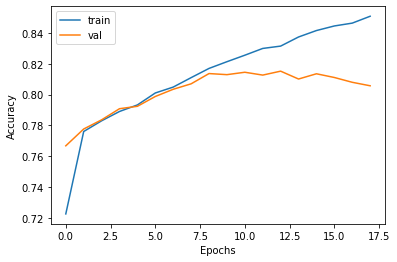

In [20]:
# Step 5: Plot accuracies
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Reconstruct paper-authors tables

- Need to add the gender

In [96]:
from tensorflow.keras.models import load_model
import unicodedata

In [24]:
pred_model = load_model('MODELS_AND_DATA/boyorgirl.h5')

In [491]:
df_authors = (
    pd.concat(
        [
            (
                pd.json_normalize(list_authors_google).assign(
                    interest=lambda x: x.apply(
                        lambda x: [
                            i["title"]
                            for i in x["author.interests"]
                            if x["author.interests"] != np.nan
                        ]
                        if isinstance(x["author.interests"], list)
                        else np.nan,
                        axis=1,
                    ),
                    email_extensition=lambda x: x["author.email"].str.replace(
                        "Verified email at ", "", regex=False
                    ),
                )
            ),
            pd.json_normalize(list_authors_google)
            .assign(
                author_clean=lambda x: x.apply(
                    lambda x: "".join(
                        (
                            c
                            for c in unicodedata.normalize("NFD", x["author.name"])
                            if unicodedata.category(c) != "Mn"
                        )
                    ),
                    axis=1,
                )
            )["author_clean"]
            .str.split(" ", expand=True),
        ],
        axis=1,
    )
    .reindex(
        columns=[
            "status",
            "search_parameters.engine",
            "search_parameters.author_id",
            "search_parameters.hl",
            "author.name",
            "author.affiliations",
            "author.email",
            "author.website",
            "author.interests",
            "author.thumbnail",
            "interest",
            "email_extensition",
            #"first_name"
        ]
    )
)
df_authors.head(1)

,status,search_parameters.engine,search_parameters.author_id,search_parameters.hl,author.name,author.affiliations,author.email,author.website,author.interests,author.thumbnail,interest,email_extensition,first_name
0,FOUND,google_scholar_author,qQZvGvIAAAAJ,en,Brahim Gaies,"Associate Professor in Economics & Finance, IPAG Lab, IPAG Business School, Paris",Verified email at ipag.fr,https://www.ipag.edu/brahim-gaies?tab=onglet1,"[{'title': 'Financial globalization', 'link': 'https://scholar.google.com/citations?view_op=search_authors&hl=en&mauthors=label:financial_globalization', 'serpapi_link': 'https://serpapi.com/search.json?engine=google_scholar_profiles&hl=en&mauthors=label%3Afinancial_globalization'}, {'title': 'Financial instability', 'link': 'https://scholar.google.com/citations?view_op=search_authors&hl=en&mauthors=label:financial_instability', 'serpapi_link': 'https://serpapi.com/search.json?engine=google_scholar_profiles&hl=en&mauthors=label%3Afinancial_instability'}, {'title': 'Development economics', 'link': 'https://scholar.google.com/citations?view_op=search_authors&hl=en&mauthors=label:development_economics', 'serpapi_link': 'https://serpapi.com/search.json?engine=google_scholar_profiles&hl=en&mauthors=label%3Adevelopment_economics'}, {'title': 'Global entrepreneurship', 'link': 'https://scholar.google.com/citations?view_op=search_authors&hl=en&mauthors=label:global_entrepreneurship', 'serpapi_link': 'https://serpapi.com/search.json?engine=google_scholar_profiles&hl=en&mauthors=label%3Aglobal_entrepreneurship'}, {'title': 'International business', 'link': 'https://scholar.google.com/citations?view_op=search_authors&hl=en&mauthors=label:international_business', 'serpapi_link': 'https://serpapi.com/search.json?engine=google_scholar_profiles&hl=en&mauthors=label%3Ainternational_business'}]",https://scholar.googleusercontent.com/citations?view_op=view_photo&user=qQZvGvIAAAAJ&citpid=1,"[Financial globalization, Financial instability, Development economics, Global entrepreneurship, International business]",ipag.fr,NaN


In [163]:
list_papers_google = pickle.load( open( "MODELS_AND_DATA/list_papers_google.pickle", "rb" ))

In [492]:
df_google_scholar = (
    pd.json_normalize(list_papers_google)
    .assign(
        nb_authors_google=lambda x: x['publication_info.authors'].str.len()
    )
)

In [493]:
df_paper_info_full = (
    pd.json_normalize(list_paper_semantic, meta=["externalIds"])
    .drop(columns=["paper_name_source"])
    .assign(nb_authors=lambda x: x["authors"].str.len())
    .merge(
        df_google_scholar.drop(columns=["title", "status"]),
        how="left",
        left_on=["externalIds.DOI"],
        right_on=["search_parameters.q"],
    )
    .assign(missing_authors_info=lambda x: x["nb_authors"] != x["nb_authors_google"])
    .reindex(
        columns=[
            "paperId",
            "url",
            "title",
            "abstract",
            "venue",
            "year",
            "nb_authors",
            "nb_authors_google",
            "missing_authors_info",
            "authors",
            "authors_details",
            "referenceCount",
            "citationCount",
            "cited_by.total",
            "cited_by.link",
            "cited_by.cites_id",
            "cited_by.serpapi_scholar_link",
            "influentialCitationCount",
            "isOpenAccess",
            "fieldsOfStudy",
            "status",
            "Levenshtein_score",
            "externalIds.MAG",
            "externalIds.DOI",
            "externalIds.DBLP",   
            "result_id",
            "link",
            "snippet",       
            "search_parameters.engine",
            "search_parameters.q",
            "search_parameters.hl",
            "publication_info.summary",
            "publication_info.authors"
        ]
    )
)
df_paper_info_full.head(1)

,paperId,url,title,abstract,venue,year,nb_authors,nb_authors_google,missing_authors_info,authors,authors_details,referenceCount,citationCount,cited_by.total,cited_by.link,cited_by.cites_id,cited_by.serpapi_scholar_link,influentialCitationCount,isOpenAccess,fieldsOfStudy,status,Levenshtein_score,externalIds.MAG,externalIds.DOI,externalIds.DBLP,result_id,link,snippet,search_parameters.engine,search_parameters.q,search_parameters.hl,publication_info.summary,publication_info.authors
0,57bf8e616da8230ca7a961be19affeb8b8ae619d,https://www.semanticscholar.org/paper/57bf8e616da8230ca7a961be19affeb8b8ae619d,"Corporate social responsibility, financial instability and corporate financial performance: Linear, non-linear and spillover effects – The case of the CAC 40 companies","Abstract This article examines the influence of corporate social responsibility (CSR) on the financial performance (CFP) for CAC 40 companies from 2002 to 2017, considering the effect of financial instability at the macro level. We based our approach on a dynamic modeling of the CFP-CSR relationship, as well as on the generalized method of moments (GMM) to overcome the problem of endogeneity. Our results show that CSR positively affects the CFP in two ways: directly, through an overall positive non-linear effect, and indirectly by mitigating the negative effect of banking crises on the CFP, which is a positive spillover effect.",,2020,2,1.0,True,"[{'authorId': '122677227', 'name': 'Abderrahmane Jahmane'}, {'authorId': '114931694', 'name': 'Brahim Gaies'}]","[{'search_parameters': {'engine': 'google_scholar_author', 'author_id': 'qQZvGvIAAAAJ', 'hl': 'en'}, 'status': 'FOUND', 'author': {'name': 'Brahim Gaies', 'affiliations': 'Associate Professor in Economics & Finance, IPAG Lab, IPAG Business School, Paris', 'email': 'Verified email at ipag.fr', 'website': 'https://www.ipag.edu/brahim-gaies?tab=onglet1', 'interests': [{'title': 'Financial globalization', 'link': 'https://scholar.google.com/citations?view_op=search_authors&hl=en&mauthors=label:financial_globalization', 'serpapi_link': 'https://serpapi.com/search.json?engine=google_scholar_profiles&hl=en&mauthors=label%3Afinancial_globalization'}, {'title': 'Financial instability', 'link': 'https://scholar.google.com/citations?view_op=search_authors&hl=en&mauthors=label:financial_instability', 'serpapi_link': 'https://serpapi.com/search.json?engine=google_scholar_profiles&hl=en&mauthors=label%3Afinancial_instability'}, {'title': 'Development economics', 'link': 'https://scholar.google.com/citations?view_op=search_authors&hl=en&mauthors=label:development_economics', 'serpapi_link': 'https://serpapi.com/search.json?engine=google_scholar_profiles&hl=en&mauthors=label%3Adevelopment_economics'}, {'title': 'Global entrepreneurship', 'link': 'https://scholar.google.com/citations?view_op=search_authors&hl=en&mauthors=label:global_entrepreneurship', 'serpapi_link': 'https://serpapi.com/search.json?engine=google_scholar_profiles&hl=en&mauthors=label%3Aglobal_entrepreneurship'}, {'title': 'International business', 'link': 'https://scholar.google.com/citations?view_op=search_authors&hl=en&mauthors=label:international_business', 'serpapi_link': 'https://serpapi.com/search.json?engine=google_scholar_profiles&hl=en&mauthors=label%3Ainternational_business'}], 'thumbnail': 'https://scholar.googleusercontent.com/citations?view_op=view_photo&user=qQZvGvIAAAAJ&citpid=1'}}]",47,14,20.0,"https://scholar.google.com/scholar?cites=15354319606549177218&as_sdt=5,39&sciodt=0,39&hl=en",15354319606549177218,https://serpapi.com/search.json?as_sdt=5%2C39&cites=15354319606549177218&engine=google_scholar&hl=en,0,False,[Economics],found,0.0,3009622282,10.1016/j.frl.2020.101483,NaN,guMt3FSAFdUJ,https://www.sciencedirect.com/science/article/pii/S1544612319314576,"This article examines the influence of corporate social responsibility (CSR) on the financial performance (CFP) for CAC 40 companies from 2002 to 2017, considering the effect of financial insta

In [184]:
df_paper_info_full['missing_authors_info'].value_counts()

True     76
False    30
Name: missing_authors_info, dtype: int64

Save to spreadsheet for validation: [PAPER_SEMANTIC_GOOGLE](https://docs.google.com/spreadsheets/d/1aK8BMsUHUVaLePtlMoM-D9wM6E9nmnBE4kaenCgdm00/edit?usp=sharing)


Need to manualy create spreadsheet, because the API does not process data with list

In [185]:
FILENAME_SPREADSHEET = "PAPER_SEMANTIC_GOOGLE"

In [192]:
df_paper_info_full.to_csv('PAPER_SEMANTIC_GOOGLE.csv', index = False)
drive.upload_file_root(mime_type = 'text/plain',
                 file_name = 'PAPER_SEMANTIC_GOOGLE.csv',
                 local_path = "PAPER_SEMANTIC_GOOGLE.csv"
                ) 
drive.move_file(file_name = 'PAPER_SEMANTIC_GOOGLE.csv', folder_name = "SPREADSHEETS_ESG_METADATA")

'1e2aAliDFToqgXQXK97oGeVxmk8fkBxrN'

Create spreadsheet authors: [AUTHOR_SEMANTIC_GOOGLE](https://docs.google.com/spreadsheets/d/1GrrQBip4qNcDuT_MEG9KhNhfTC3yFsVZUtP8-SvXBL4/edit?usp=sharing)

Once again, use levensthein to match them. No need to be fancy

In [229]:
import jellyfish

In [303]:
pd.json_normalize(list_paper_semantic, "authors")["name"].nunique()

266

In [302]:
df_authors["author.name"].nunique()

147

In [494]:
match_author = (
    pd.DataFrame(
        index=pd.MultiIndex.from_product(
            [
                pd.json_normalize(list_paper_semantic, "authors")["name"].unique(),
                df_authors["author.name"].unique(),
            ],
            names=["semantic", "google"],
        )
    )
    .reset_index()
    .apply(lambda x: x.str.lower())
    .assign(
        semantic=lambda x: x.apply(
            lambda x: "".join(
                (
                    c
                    for c in unicodedata.normalize("NFD", x["semantic"])
                    if unicodedata.category(c) != "Mn"
                )
            ),
            axis=1,
        ),
        google=lambda x: x.apply(
            lambda x: "".join(
                (
                    c
                    for c in unicodedata.normalize("NFD", x["google"])
                    if unicodedata.category(c) != "Mn"
                )
            ),
            axis=1,
        ),
        score_lev = lambda x: x.apply(lambda x: jellyfish.levenshtein_distance(x['semantic'], x['google']),axis =1),
        min_score_lev = lambda x: x.groupby('google')['score_lev'].transform(min),
        score_jaro= lambda x: x.apply(lambda x: jellyfish.jaro_distance(x['semantic'], x['google']),axis =1),
        max_score_jaro = lambda x: x.groupby('google')['score_jaro'].transform(max),
        score_d_lev= lambda x: x.apply(lambda x: jellyfish.damerau_levenshtein_distance(x['semantic'], x['google']),axis =1),
        min_score_d_lev = lambda x: x.groupby('google')['score_d_lev'].transform(min),
        score_hamming= lambda x: x.apply(lambda x: jellyfish.hamming_distance(x['semantic'], x['google']),axis =1),
        min_score_hamming = lambda x: x.groupby('google')['score_hamming'].transform(min)
    )
)

In [496]:
import requests
def twinword(token1, token2):
    """
    """
    url = "https://api.twinword.com/api/text/similarity/latest/"
    headers = {
        'Host': "api.twinword.com",
        "X-Twaip-Key": "T2pS4kaW7BQBP0eoXJU5HHhvYtYYJfGTWorsyviz3Kc+7eFxyboqdJYc4xAEyptg1eURGJdeURGCjlE3sjffFw=="
    }
    querystring = {
        "text1": token1,
        "text2": token2
    }
    response = requests.get(url, headers=headers,params=querystring)
    return response.json()['similarity']
    

In [497]:
test = (
    match_author
    .loc[lambda x: x['score_lev'] == x['min_score_lev']]
    .sort_values(by = ['min_score_lev', "semantic",'google'])
    .assign( 
        similarity = lambda x: x.apply(lambda x: twinword(x['semantic'], x['google']), axis= 1),
        max_similarity = lambda x: x.groupby('semantic')['similarity'].transform(max)
    )
    .loc[lambda x: x['score_lev'] == x['min_score_lev']]
)

In [498]:
test['google'].nunique()

147

Test 1: 125 exact match

- authors with large similarity score and only one observation by author

In [499]:
test_1 = (
    test
    .assign( 
        size = lambda x: x.groupby('google')['google'].transform("size"),
    )
    .loc[lambda x: (x['size'] ==1) & (x['max_similarity'] >0.1)]
    .loc[lambda x: (x['similarity'] ==x['max_similarity'])]
    .sort_values(by = ['max_similarity', "semantic",'google'])
)
test_1['google'].nunique()

125

Test 2: 7 exact match

- authors with large similarity score and if duplicates lowest hammer

In [500]:
test_2 = (
    test
    .loc[lambda x: ~x['google'].isin(test_1['google'].unique())]
    .loc[lambda x:(x['similarity'] >0)]
    .assign( 
        size = lambda x: x.groupby('google')['google'].transform("size"),
        min_score_hamming = lambda x: x.groupby('google')['score_hamming'].transform(min)
    )
    .loc[lambda x:(x['min_score_hamming'] == x['score_hamming'])]
)
test_2['google'].nunique()

7

We found 136 authors among the 266:

- We now need to match Google's authors information, and then match with semantic authors' list to see the authors not match
- We remove the duplicate by keeping the highest complexity value within authors

In [527]:
df_authors_full = (
    pd.concat(
        [
            (
                pd.concat([test_2, test_1])
                .reindex(columns=["google", "semantic", "similarity"])
                .merge(
                    (
                        df_authors.drop_duplicates(subset="author.name").assign(
                            google=lambda x: x.apply(
                                lambda x: "".join(
                                    (
                                        c
                                        for c in unicodedata.normalize("NFD", x["author.name"])
                                        if unicodedata.category(c) != "Mn"
                                    )
                                ),
                                axis=1,
                            ).str.lower()
                        )
                    ),
                    how="left",
                    on=["google"],
                )
                .assign(
                    size=lambda x: x.groupby("semantic")[
                        "semantic"].transform("size"),
                    max_similarity=lambda x: x.groupby(
                        "semantic")["similarity"].transform(max),
                )
                .loc[lambda x: x["max_similarity"] == x["similarity"]]
                .assign(
                    google_0=lambda x: x['google'].str.split(" ", expand=True)[
                        0],
                    semantic_0=lambda x: x['semantic'].str.split(" ", expand=True)[
                        0],
                    preprocessed_0=lambda x: preprocess(
                        x.reindex(columns=["google_0"]), column="google_0", train=False
                    ),
                    preprocessed_1=lambda x: preprocess(
                        x.reindex(columns=["semantic_0"]), column="semantic_0", train=False
                    ),
                    preds_0=lambda x:
                    pred_model.predict(
                        np.asarray(x["preprocessed_0"].values.tolist())
                    ),
                    preds_1=lambda x:
                    pred_model.predict(
                        np.asarray(x["preprocessed_1"].values.tolist())
                    )
                )
                .assign(
                    preds_1=lambda x: np.where(x["semantic_0"].str.len() <3, np.nan, x['preds_1'])
                )
            ),
            (
                pd.json_normalize(list_paper_semantic, "authors")
                .apply(lambda x: x.str.lower())
                .assign(
                    semantic=lambda x: x.apply(
                        lambda x: "".join(
                            (
                                c
                                for c in unicodedata.normalize("NFD", x["name"])
                                if unicodedata.category(c) != "Mn"
                            )
                        ),
                        axis=1,
                    )
                )
                .drop_duplicates()
                .loc[
                    lambda x: ~x["semantic"].isin(
                        list(pd.concat([test_2, test_1])["semantic"])
                    )
                ]
                .drop(columns=["name"])
                .assign(
                    semantic_0=lambda x: x['semantic'].str.split(" ", expand=True)[
                        0],
                    preprocessed_1=lambda x: preprocess(
                        x.reindex(columns=["semantic_0"]), column="semantic_0", train=False
                    ),
                    preds_1=lambda x:
                    pred_model.predict(
                        np.asarray(x["preprocessed_1"].values.tolist())
                    ),
                )
                .assign(
                    preds_1=lambda x: np.where(x["semantic_0"].str.len() <3, np.nan, x['preds_1']),
                )
            ),
        ],
        axis=0,
    )
    .assign(
        missing=lambda x: x['google'].isin([np.nan]),
        max_prob = lambda x: x[['preds_0' ,'preds_1']].max(axis=1),
        gender=lambda x: np.where(x["max_prob"] > 0.5, "MALE", "FEMALE"),
    )
    .sort_values(by=['missing', 'semantic'])
)

In [530]:
df_authors_full['gender'].value_counts()

MALE      139
FEMALE    127
Name: gender, dtype: int64

In [529]:
df_authors_full.shape

(266, 28)

Add journals to update the information in Google spreadsheet

In [539]:
df_authors_journal_full = (
    df_paper_info_full.assign(
        authors_list=lambda x: x.apply(
            lambda x: [i["name"]
                       for i in x["authors"] if x["authors"] != np.nan]
            if isinstance(x["authors"], list)
            else np.nan,
            axis=1,
        )
    )
    .explode("authors_list")
    .assign(
        authors_list=lambda x: x["authors_list"].str.lower(),
        semantic=lambda x: x.apply(
            lambda x: "".join(
                (
                    c
                    for c in unicodedata.normalize("NFD", x["authors_list"])
                    if unicodedata.category(c) != "Mn"
                )
            ),
            axis=1,
        ),
    )
    .merge(df_authors_full, how="left", on=["semantic"])
    .reindex(columns=['paperId',
                      'url',
                      'title',
                      'abstract',
                      'venue',
                      'year',
                      'nb_authors',
                      'nb_authors_google',
                      'missing_authors_info',
                      'authors',
                      'authors_details',
                      'referenceCount',
                      'citationCount',
                      'cited_by.total',
                      'cited_by.link',
                      'cited_by.cites_id',
                      'cited_by.serpapi_scholar_link',
                      'influentialCitationCount',
                      'isOpenAccess',
                      'fieldsOfStudy',
                      'Levenshtein_score',
                      'externalIds.MAG',
                      'externalIds.DOI',
                      'externalIds.DBLP',
                      'result_id',
                      'link',
                      'snippet',
                      'search_parameters.engine_x',
                      'search_parameters.q',
                      'search_parameters.hl_x',
                      'publication_info.summary',
                      'publication_info.authors',
                      'authors_list',
                      'semantic',
                      'google',
                      'gender',
                      'preds_0',
                      'preds_1',
                      'authorId',
                      'missing',
                      'max_prob',
                      'similarity',
                      'status_y',
                      'search_parameters.engine_y',
                      'search_parameters.author_id',
                      'search_parameters.hl_y',
                      'author.name',
                      'author.affiliations',
                      'author.email',
                      'author.website',
                      'author.interests',
                      'author.thumbnail',
                      'interest',
                      'email_extensition',
                      'max_similarity',
                      'google_0',
                      'semantic_0'
                      ])
)

In [540]:
FILENAME_SPREADSHEET = "AUTHOR_SEMANTIC_GOOGLE"
df_authors_journal_full.to_csv('AUTHOR_SEMANTIC_GOOGLE.csv', index = False)
drive.upload_file_root(mime_type = 'text/plain',
                 file_name = 'AUTHOR_SEMANTIC_GOOGLE.csv',
                 local_path = "AUTHOR_SEMANTIC_GOOGLE.csv"
                ) 
drive.move_file(file_name = 'AUTHOR_SEMANTIC_GOOGLE.csv', folder_name = "SPREADSHEETS_ESG_METADATA")

Found file: SPREADSHEETS_ESG_METADATA (1GxZg6aF5H1JMfGulEoNCbLZVnJqSpSMh)
Found file: AUTHOR_SEMANTIC_GOOGLE.csv (1Icx_0cwwc4G0qnVyAXLHlaiauB9yKAp1)
File AUTHOR_SEMANTIC_GOOGLE.csv moved to SPREADSHEETS_ESG_METADATA


{'file_name': 'AUTHOR_SEMANTIC_GOOGLE.csv',
 'folder_name': 'SPREADSHEETS_ESG_METADATA'}

# Table `meta_analysis_esg_cfp`

Since the table to create has missing value, please use the following at the top of the query

```
CREATE TABLE database.table_name WITH (format = 'PARQUET') AS
```

Choose a location in S3 to save the CSV. It is recommended to save in it the `datalake-datascience` bucket. Locate an appropriate folder in the bucket, and make sure all output have the same format

In [ ]:
s3_output = 'DATA/FINANCE/ESG/ESG_CFP'
table_name = 'meta_analysis_esg_cfp'

First, we need to delete the table (if exist)

In [ ]:
try:
    response = glue.delete_table(
        database=DatabaseName,
        table=table_name
    )
    print(response)
except Exception as e:
    print(e)

Clean up the folder with the previous csv file. Be careful, it will erase all files inside the folder

In [ ]:
s3.remove_all_bucket(path_remove = s3_output)

In [ ]:
%%time
query = """
CREATE TABLE {0}.{1} WITH (format = 'PARQUET') AS
WITH merge AS (
  SELECT 
    id, 
    image,
    row_id_excel,
    table_refer,
    row_id_google_spreadsheet,
    incremental_id,
    paper_name, 
    publication_year, 
    publication_type, 
    regexp_replace(
      regexp_replace(
        lower(publication_name), 
        '\&', 
        'and'
      ), 
      '\-', 
      ' '
    ) as publication_name, 
    cnrs_ranking, 
    UPPER(peer_reviewed) as peer_reviewed, 
    UPPER(study_focused_on_social_environmental_behaviour) as study_focused_on_social_environmental_behaviour, 
    type_of_data, 
    CASE WHEN regions = 'ARAB WORLD' THEN 'WORLDWIDE' ELSE regions END AS regions,
    CASE WHEN study_focusing_on_developing_or_developed_countries = 'Europe' THEN 'WORLDWIDE' ELSE UPPER(study_focusing_on_developing_or_developed_countries) END AS study_focusing_on_developing_or_developed_countries,
    first_date_of_observations,
    last_date_of_observations,
    CASE WHEN first_date_of_observations >= 1997 THEN 'YES' ELSE 'NO' END AS kyoto,
    CASE WHEN first_date_of_observations >= 2009 THEN 'YES' ELSE 'NO' END AS financial_crisis,
    last_date_of_observations - first_date_of_observations as windows,
    adjusted_model_name,
    adjusted_model,
    dependent, 
    adjusted_dependent,
    independent,
    adjusted_independent, 
    social,
    environmental,
    governance,
    sign_of_effect,
    target,
    p_value_significant,
    sign_positive,
    sign_negative,
    lag, 
    interaction_term, 
    quadratic_term, 
    n, 
    r2, 
    beta, 
    to_remove,
    test_standard_error,
    test_p_value,
    test_t_value,
    adjusted_standard_error,
    adjusted_t_value
  FROM 
    esg.papers_meta_analysis_new 
    LEFT JOIN (
      SELECT 
        DISTINCT(title),
        nr, 
        publication_year, 
        publication_type, 
        publication_name, 
        cnrs_ranking, 
        peer_reviewed, 
        study_focused_on_social_environmental_behaviour, 
        type_of_data, 
        study_focusing_on_developing_or_developed_countries
      FROM 
        esg.papers_meta_analysis
    ) as old on papers_meta_analysis_new.id = old.nr
    -- WHERE to_remove = 'TO_KEEP'
LEFT JOIN (
SELECT 
        nr,
        CAST(MIN(first_date_of_observations) as int) as first_date_of_observations,
        CAST(MAX(last_date_of_observations)as int) as last_date_of_observations,
        min(row_id_excel) as row_id_excel
      FROM 
        esg.papers_meta_analysis
        GROUP BY nr
) as date_pub on papers_meta_analysis_new.id = date_pub.nr
LEFT JOIN (
SELECT 
  nr, 
  MIN(regions) as regions 
FROM 
  (
    SELECT 
      nr, 
      CASE WHEN regions_of_selected_firms in (
        'Cameroon', 'Egypt', 'Libya', 'Morocco', 
        'Nigeria'
      ) THEN 'AFRICA' WHEN regions_of_selected_firms in ('GCC countries') THEN 'ARAB WORLD' WHEN regions_of_selected_firms in (
        'India', 'Indonesia', 'Taiwan', 'Vietnam', 
        'Australia', 'China', 'Iran', 'Malaysia', 
        'Pakistan', 'South Korea', 'Bangladesh'
      ) THEN 'ASIA AND PACIFIC' WHEN regions_of_selected_firms in (
        'Spain', '20 European countries', 
        'United Kingdom', 'France', 'Germany, Italy, the Netherlands and United Kingdom', 
        'Turkey', 'UK'
      ) THEN 'EUROPE' WHEN regions_of_selected_firms in ('Latin America', 'Brazil') THEN 'LATIN AMERICA' WHEN regions_of_selected_firms in ('USA', 'US', 'U.S.', 'Canada') THEN 'NORTH AMERICA' ELSE 'WORLDWIDE' END AS regions 
    FROM 
      papers_meta_analysis
  ) 
GROUP BY 
  nr
) as reg on papers_meta_analysis_new.id = reg.nr
) 
SELECT 
    to_remove, 
    id, 
    image,
    row_id_excel,
    row_id_google_spreadsheet,
    table_refer,
    incremental_id,
    paper_name,
    publication_name,
    rank,
    sjr, 
    sjr_best_quartile, 
    h_index, 
    total_docs_2020, 
    total_docs_3years, 
    total_refs, 
    total_cites_3years, 
    citable_docs_3years, 
    cites_doc_2years, 
    country ,
    publication_year, 
    publication_type, 
    cnrs_ranking, 
    peer_reviewed, 
    study_focused_on_social_environmental_behaviour, 
    type_of_data, 
    regions,
    study_focusing_on_developing_or_developed_countries,
    first_date_of_observations,
    last_date_of_observations - (windows/2) as mid_year,
    last_date_of_observations,
    kyoto,
    financial_crisis,
    windows,
    adjusted_model_name,
    adjusted_model,
    dependent, 
    adjusted_dependent,
    independent,
    adjusted_independent, 
    social,
    environmental,
    governance,
    sign_of_effect,
    target,
    p_value_significant,
    sign_positive,
    sign_negative,
    lag, 
    interaction_term, 
    quadratic_term, 
    n, 
    r2, 
    beta, 
    test_standard_error,
    test_p_value,
    test_t_value,
    adjusted_standard_error,
    adjusted_t_value 
FROM 
  merge 
  LEFT JOIN (
    SELECT 
      rank, 
      regexp_replace(
        regexp_replace(
          lower(title), 
          '\&', 
          'and'
        ), 
        '\-', 
        ' '
      ) as title, 
      sjr, 
      sjr_best_quartile, 
      h_index, 
      total_docs_2020, 
      total_docs_3years, 
      total_refs, 
      total_cites_3years, 
      citable_docs_3years, 
      cites_doc_2years, 
      country 
    FROM 
      "scimago"."journals_scimago"
    WHERE sourceid not in (16400154787)
  ) as journal on merge.publication_name = journal.title
""".format(DatabaseName, table_name)
output = s3.run_query(
                    query=query,
                    database=DatabaseName,
                    s3_output=s3_output,
                )
output

In [ ]:
query_count = """
SELECT COUNT(*) AS CNT
FROM {}.{} 
""".format(DatabaseName, table_name)
output = s3.run_query(
                    query=query_count,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'count_{}'.format(table_name)
                )
output

# Update Glue catalogue and Github

This step is mandatory to validate the query in the ETL.

## Create or update the data catalog

The query is saved in the S3 (bucket `datalake-london`), but the comments are not available. Use the functions below to update the catalogue and Github


Update the dictionary

- DatabaseName:
- TableName:
- ~TablePrefix:~
- input: 
- filename: Name of the notebook or Python script: to indicate
- Task ID: from Coda
- index_final_table: a list to indicate if the current table is used to prepare the final table(s). If more than one, pass the index. Start at 0
- if_final: A boolean. Indicates if the current table is the final table -> the one the model will be used to be trained
- schema: glue schema with comment
- description: details query objective

**Update schema**

If `automatic = False` in `automatic_update`, then the function returns only the variables to update the comments. Manually add the comment, **then**, pass the new schema (only the missing comment) to the argument `new_schema`. 

To update the schema, please use the following structure

```
schema = [
    {
        "Name": "VAR1",
        "Type": "",
        "Comment": ""
    },
    {
        "Name": "VAR2",
        "Type": "",
        "Comment": ""
    }
]
```

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc
import create_schema
import create_report
import update_glue_github

The function below manages everything automatically. If the final table comes from more than one query, then pass a list of table in `list_tables` instead of `automatic`

In [ ]:
list_input,  schema = update_glue_github.automatic_update(
    list_tables = 'automatic',
    automatic= True,
    new_schema = None, ### override schema
    client = client,
    TableName = table_name,
    query = query)

In [ ]:
description = """
Create table with journal information, papers and coefficients for the meta analysis
"""
name_json = 'parameters_ETL_esg_metadata.json'
partition_keys = ["id", 'incremental_id']
notebookname = "00_meta_analysis.ipynb"
dic_information = {
    "client":client,
    'bucket':bucket,
    's3_output':s3_output,
    'DatabaseName':DatabaseName,
    'TableName':table_name,
    'name_json':name_json,
    'partition_keys':partition_keys,
    'notebookname':notebookname,
    'index_final_table':[0],
    'if_final': 'True',
    'schema':schema,
    'description':description,
    'query':query,
    "list_input":list_input,
    'list_input_automatic':True
}

In [ ]:
update_glue_github.update_glue_github(client = client,dic_information = dic_information)

## Check Duplicates

One of the most important step when creating a table is to check if the table contains duplicates. The cell below checks if the table generated before is empty of duplicates. The code uses the JSON file to create the query parsed in Athena. 

You are required to define the group(s) that Athena will use to compute the duplicate. For instance, your table can be grouped by COL1 and COL2 (need to be string or varchar), then pass the list ['COL1', 'COL2'] 

In [ ]:
update_glue_github.find_duplicates(
    client = client,
    bucket = bucket,
    name_json = name_json,
    partition_keys = partition_keys,
    TableName= table_name
)

## Count missing values

In [ ]:
update_glue_github.count_missing(client = client, name_json = name_json, bucket = bucket,TableName = table_name)

# Update Github Data catalog

The data catalog is available in Glue. Although, we might want to get a quick access to the tables in Github. In this part, we are generating a `README.md` in the folder `00_data_catalogue`. All tables used in the project will be added to the catalog. We use the ETL parameter file and the schema in Glue to create the README. 

Bear in mind the code will erase the previous README. 

In [ ]:
create_schema.make_data_schema_github(name_json = name_json)

# Analytics

In this part, we are providing basic summary statistic. Since we have created the tables, we can parse the schema in Glue and use our json file to automatically generates the analysis.

The cells below execute the job in the key `ANALYSIS`. You need to change the `primary_key` and `secondary_key` 

For a full analysis of the table, please use the following Lambda function. Be patient, it can takes between 5 to 30 minutes. Times varies according to the number of columns in your dataset.

Use the function as follow:

- `output_prefix`:  s3://datalake-datascience/ANALYTICS/OUTPUT/TABLE_NAME/
- `region`: region where the table is stored
- `bucket`: Name of the bucket
- `DatabaseName`: Name of the database
- `table_name`: Name of the table
- `group`: variables name to group to count the duplicates
- `primary_key`: Variable name to perform the grouping -> Only one variable for now
- `secondary_key`: Variable name to perform the secondary grouping -> Only one variable for now
- `proba`: Chi-square analysis probabilitity
- `y_var`: Continuous target variables

Check the job processing in Sagemaker: https://eu-west-3.console.aws.amazon.com/sagemaker/home?region=eu-west-3#/processing-jobs

The notebook is available: https://s3.console.aws.amazon.com/s3/buckets/datalake-datascience?region=eu-west-3&prefix=ANALYTICS/OUTPUT/&showversions=false

Please, download the notebook on your local machine, and convert it to HTML:

```
cd "/Users/thomas/Downloads/Notebook"
aws s3 cp s3://datalake-datascience/ANALYTICS/OUTPUT/asif_unzip_data_csv/Template_analysis_from_lambda-2020-11-22-08-12-20.ipynb .

## convert HTML no code
jupyter nbconvert --no-input --to html Template_analysis_from_lambda-2020-11-21-14-30-45.ipynb
jupyter nbconvert --to html Template_analysis_from_lambda-2020-11-22-08-12-20.ipynb
```

Then upload the HTML to: https://s3.console.aws.amazon.com/s3/buckets/datalake-datascience?region=eu-west-3&prefix=ANALYTICS/HTML_OUTPUT/

Add a new folder with the table name in upper case

In [ ]:
import boto3

key, secret_ = con.load_credential()
client_lambda = boto3.client(
    'lambda',
    aws_access_key_id=key,
    aws_secret_access_key=secret_,
    region_name = region)

In [ ]:
primary_key = ''
secondary_key = ''
y_var = ''

In [ ]:
payload = {
    "input_path": "s3://datalake-datascience/ANALYTICS/TEMPLATE_NOTEBOOKS/template_analysis_from_lambda.ipynb",
    "output_prefix": "s3://datalake-datascience/ANALYTICS/OUTPUT/{}/".format(table_name.upper()),
    "parameters": {
        "region": "{}".format(region),
        "bucket": "{}".format(bucket),
        "DatabaseName": "{}".format(DatabaseName),
        "table_name": "{}".format(table_name),
        "group": "{}".format(','.join(partition_keys)),
        "keys": "{},{}".format(primary_key,secondary_key),
        "y_var": "{}".format(y_var),
        "threshold":0
    },
}
payload

In [ ]:
#response = client_lambda.invoke(
#    FunctionName='RunNotebook',
#    InvocationType='RequestResponse',
#    LogType='Tail',
#    Payload=json.dumps(payload),
#)
#response

# Generation report

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp

In [ ]:
create_report.create_report(extension = "html", keep_code = True, notebookname =  notebookname)

In [ ]:
create_schema.create_schema(name_json, path_save_image = os.path.join(parent_path, 'utils'))

In [ ]:
### Update TOC in Github
for p in [parent_path,
          str(Path(path).parent),
          os.path.join(str(Path(path).parent), "00_download_data"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "00_statistical_exploration"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "01_model_estimation"),
         ]:
    try:
        os.remove(os.path.join(p, 'README.md'))
    except:
        pass
    path_parameter = os.path.join(parent_path,'utils', name_json)
    md_lines =  make_toc.create_index(cwd = p, path_parameter = path_parameter)
    md_out_fn = os.path.join(p,'README.md')
    
    if p == parent_path:
    
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = True, path_parameter = path_parameter)
    else:
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = False)